# Cluster Analysis of BostonBlueBikes

In [45]:
import numpy as np
import pandas as pd
import folium
from math import sin, cos, pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt



## Load processed dataframe

In [59]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122554 entries, 0 to 1122553
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   Unnamed: 0               1122554 non-null  int64         
 1   start_time               1122554 non-null  datetime64[ns]
 2   end_time                 1122554 non-null  datetime64[ns]
 3   start_station_id         1122554 non-null  int64         
 4   end_station_id           1122554 non-null  string        
 5   start_station_name       1122554 non-null  string        
 6   end_station_name         1122554 non-null  string        
 7   bike_id                  1122554 non-null  int64         
 8   user_type                1122554 non-null  string        
 9   trip_length              1122554 non-null  float64       
 10  start_station_latitude   1122554 non-null  float64       
 11  start_station_longitude  1122554 non-null  float64       
 12  

In [60]:
df_boston.head()

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075
1,1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445
2,2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100
3,3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075
4,4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427


In [ ]:
## todo cluster trip types/customer types
## cluster areas/station types (?) -> university, center ...


## Clustering of trip types

### Prepare Data

##### We prepare a dataframe that simply includes time of rental as well as the trip length. We consider not only daytime and weekday but also what part of the year (season) the bike was rented. 

In [ ]:
#features: hour, day, season, duration

In [95]:
df_trip_types = df_boston[['start_time', 'end_time', 'trip_length']].copy()
df_trip_types.loc[:,'hour'] = df_trip_types['start_time'].apply( lambda x: x.hour + (x.minute/60))
df_trip_types.loc[:, 'weekday'] = df_trip_types['start_time'].apply(lambda x: x.day_of_week)
#df_trip_types.loc[:, 'season'] = df_trip_types['start_time'].apply(lambda x: x.month%12//3 +1)

In [69]:
df_trip_types.head()

,start_time,end_time,trip_length,hour,weekday
0,2015-01-01 00:21:44,2015-01-01 00:30:47,543.0,0.350000,3
1,2015-01-01 00:27:03,2015-01-01 00:34:21,438.0,0.450000,3
2,2015-01-01 00:31:31,2015-01-01 00:35:46,255.0,0.516667,3
3,2015-01-01 00:53:46,2015-01-01 01:00:58,432.0,0.883333,3
4,2015-01-01 01:07:06,2015-01-01 01:19:21,735.0,1.116667,3


In [96]:
df_trip_types = df_trip_types.rename(columns = {'trip_length' : 'duration_in_sec'})

##### Include circular feature of time variables -> otherwise problem with stanrardization (why?)

In [97]:
def circular( name, feature, dataframe, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular('hour', df_trip_types['hour'], df_trip_types, 24)
circular('weekday', df_trip_types['weekday'], df_trip_types, 7)
#circular('season', df_trip_types['season'], df_trip_types, 4)

df_trip_types_c = df_trip_types.drop(['hour', 'weekday', 'start_time', 'end_time'], axis = 1)


##### Scaling variables to ensure same weights

In [114]:
scaler= StandardScaler()
scaler.fit(df_trip_types_c)
X_scaled = scaler.transform(df_trip_types_c)
X_scaled_df = pd.DataFrame(X_scaled, columns = df_trip_types_c.columns, index = df_trip_types.index)
X_scaled_df

,duration_in_sec,hour_sin,hour_cos,weekday_sin,weekday_cos
0,-0.019441,0.527893,2.322666,0.519928,-1.193226
1,-0.022561,0.564513,2.317805,0.519928,-1.193226
2,-0.028000,0.588864,2.313892,0.519928,-1.193226
3,-0.022740,0.721567,2.282826,0.519928,-1.193226
4,-0.013734,0.804544,2.254743,0.519928,-1.193226
...,...,...,...,...,...
1122549,-0.020986,0.246075,2.319560,0.519928,-1.193226
1122550,-0.017539,0.258282,2.321180,0.519928,-1.193226
1122551,-0.019233,0.264389,2.321940,0.519928,-1.193226
1122552,-0.032013,0.313332,2.326806,0.519928,-1.193226


#### What k to choose? -> elbow method

In [115]:
k_max = 15
clusters = []
loss = []

for k in range(k_max):
    model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_df)
    clusters.append(k+1)
    loss.append(model.inertia_)


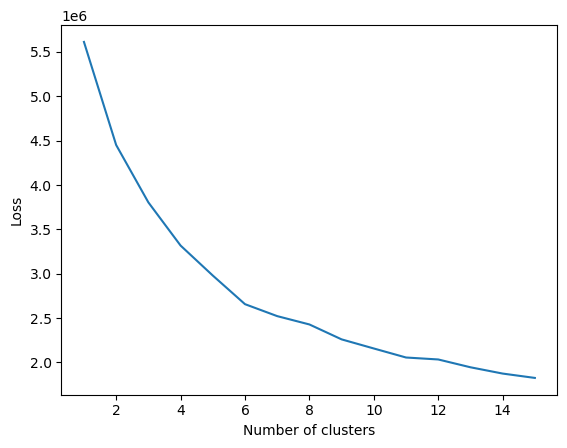

In [102]:
plt.plot(clusters, loss)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

### Clustering

In [116]:
# refit algorithm
means = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means.fit(X_scaled)

cluster_means = ['one', 'two', 'three', 'four', 'five', 'six', 'seven']

#add cluster lables to the dataset
X_scaled_df["cluster"] = means.predict(X_scaled)
X_scaled_df["cluster"] = X_scaled_df["cluster"].apply(lambda x: cluster_means[x])

X_scaled_df["duration_in_sec"]= df_trip_types.duration_in_sec
X_scaled_df["hour"]=df_trip_types.hour
X_scaled_df["weekday"]=df_trip_types.weekday
#X_scaled_df["start_station_id"]=df_trip_types.start_station_id



In [113]:
X_scaled_df

,duration_in_sec,hour_sin,hour_cos,weekday_sin,weekday_cos,cluster,trip_duration,hour,day_of_week,weekday
0,543.0,0.527893,2.322666,0.519928,-1.193226,seven,543.0,0.350000,3,3
1,438.0,0.564513,2.317805,0.519928,-1.193226,seven,438.0,0.450000,3,3
2,255.0,0.588864,2.313892,0.519928,-1.193226,seven,255.0,0.516667,3,3
3,432.0,0.721567,2.282826,0.519928,-1.193226,seven,432.0,0.883333,3,3
4,735.0,0.804544,2.254743,0.519928,-1.193226,seven,735.0,1.116667,3,3
...,...,...,...,...,...,...,...,...,...,...
1122549,491.0,0.246075,2.319560,0.519928,-1.193226,seven,491.0,23.583333,3,3
1122550,607.0,0.258282,2.321180,0.519928,-1.193226,seven,607.0,23.616667,3,3
1122551,550.0,0.264389,2.321940,0.519928,-1.193226,seven,550.0,23.633333,3,3
1122552,120.0,0.313332,2.326806,0.519928,-1.193226,seven,120.0,23.766667,3,3


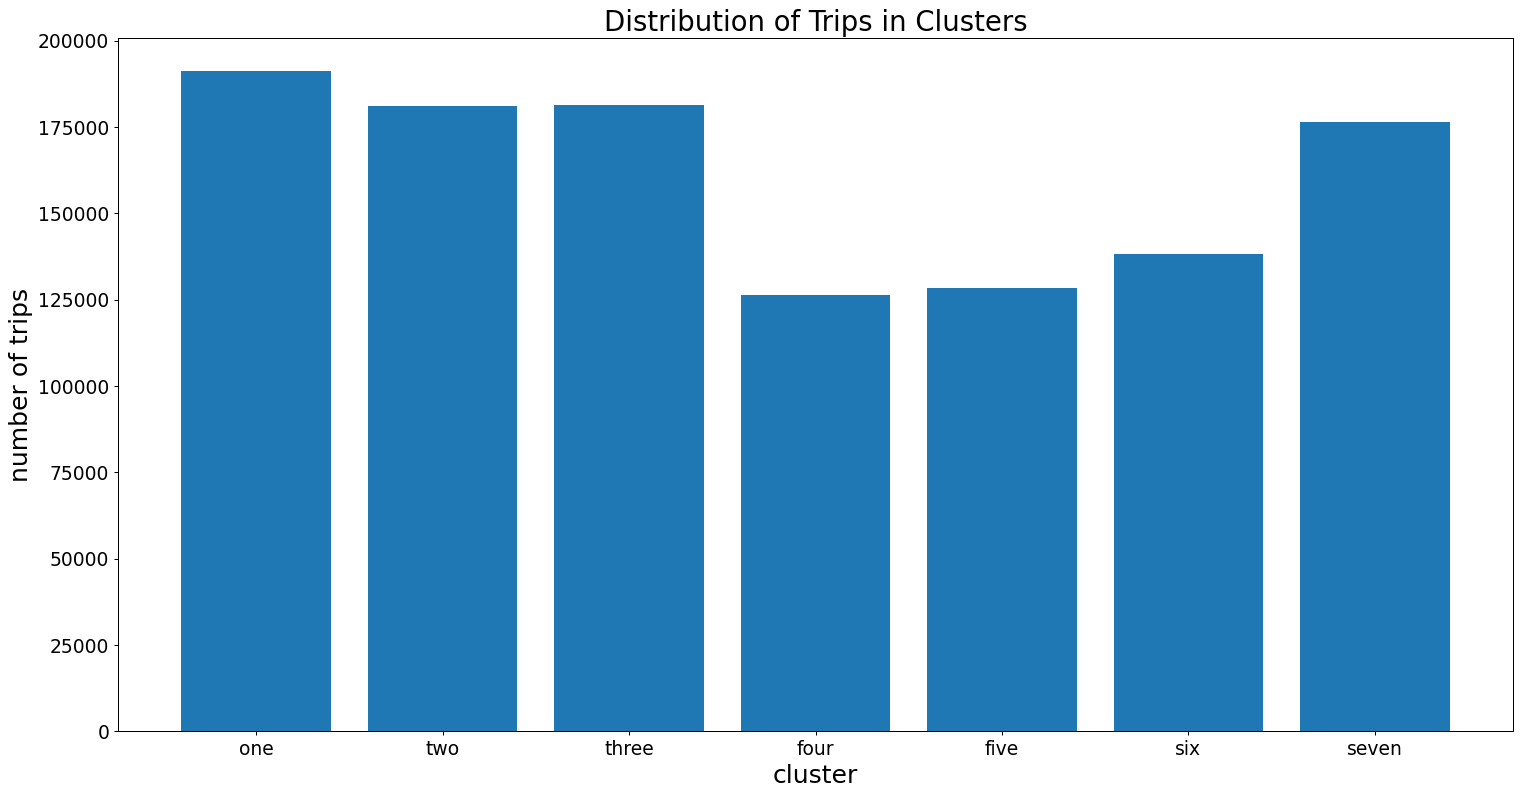

In [117]:
count = [len(X_scaled_df[X_scaled_df.cluster==cluster_means[i]]) for i in range(len(cluster_means))]

fig,ax = plt.subplots(figsize=(20,10), dpi=90) 
axis_font = {'size':'20'}
label_font = {'labelsize':'15'}
dic={'fontsize': '22'}

ax.set_title("Distribution of Trips in Clusters", dic)
ax.set_ylabel("number of trips", **axis_font)
ax.set_xlabel("cluster", **axis_font)
ax.tick_params(axis='both', **label_font)
    
plt.bar(cluster_means,count)
plt.show()